In [5]:
pwd

'/mmfs1/data/aglinska/BC-fMRI-AE/Notebooks'

In [190]:
import numpy as np
import os
import seaborn as sns
from matplotlib import pyplot as plt
from helper_funcs import *
from tqdm import tqdm
import pandas as pd

In [200]:
rnames = pd.read_csv('../Data/YeoAtlas/roinames.txt',header=None)
rlbls = rnames.values
rord = np.array([19, 44, 16, 12, 39, 18, 43, 14, 15, 42, 20, 45, 17, 41, 13, 40, 21, 46, 24, 50, 23, 49, 48, 25, 22, 47, 3, 29, 2, 28, 4, 30, 10, 37, 11, 38, 7, 33, 9, 36, 5, 8, 35, 34, 32, 6, 31, 1, 27, 0, 26])

In [48]:
data = np.load('../Data/rel-cmats.npz',allow_pickle=True)
scan_lenghts = np.load('../Data/scan_lenghts.npz',allow_pickle=True)['arr']
cmats = data['arr']
subs = data['subs']

print(cmats.shape)
print(subs.shape)

(1102, 51, 51, 2)
(1102,)


In [49]:
has_nans = [np.isnan(cmats[i,:,:,:].flatten()).sum()==0 for i in range(cmats.shape[0])]
has_nans = np.array(has_nans)
has_nans.mean()

0.985480943738657

In [50]:
cmats = cmats[has_nans,:,:,:]
subs = subs[has_nans]
scan_lenghts = scan_lenghts[has_nans]

In [53]:
n = len(subs)

In [51]:
cmats.shape

(1086, 51, 51, 2)

In [259]:
(scan_lenghts < 4.5).sum()

27

In [ ]:
halves_corr = [corr(get_triu(cmats[s,:,:,0]),get_triu(cmats[s,:,:,1]))[0,1] for s in range(n)]
halves_corr = np.array(halves_corr)
halves_corr.shape

In [185]:
f'M = {halves_corr.mean():.2f}, SD = {halves_corr.std():.2f}'

'M = 0.72, SD = 0.08'

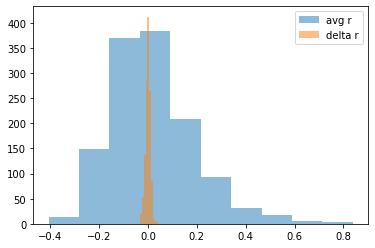

In [255]:
plt.hist(get_triu(cmats.mean(axis=-1).mean(axis=0)),alpha=.5)
plt.hist(get_triu(diff.mean(axis=0)),alpha=.5)
plt.legend(['avg r','delta r'])

Text(0, 0.5, 'delta corr')

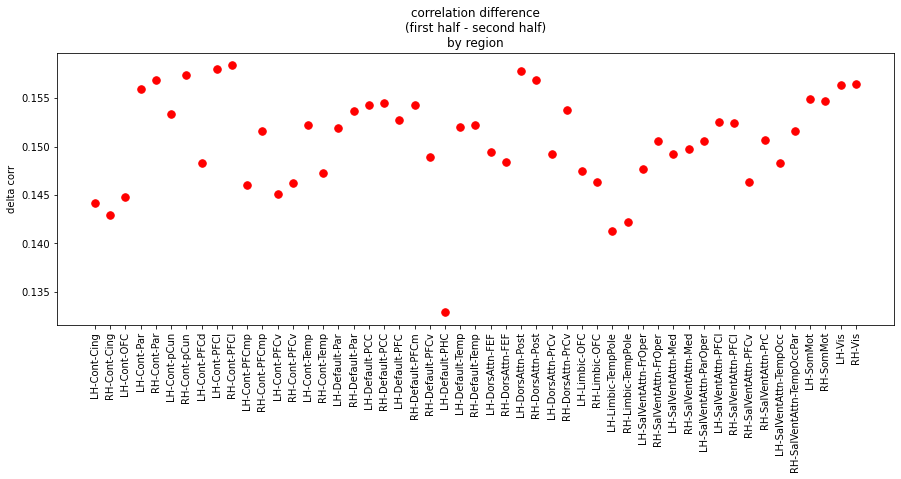

In [260]:
plt.figure(figsize=(15,5))
diff = (cmats[:,:,:,0]-cmats[:,:,:,1])
diff = abs(diff)
ys = diff.mean(axis=0).mean(axis=0)
ys = ys[rord]
lbls = np.array([l[0].replace("'",'') for l in rlbls])
lbls = lbls[rord]
#lbls = rlbls[rord]


plt.plot(ys,'r.',markersize=15)
plt.xticks(np.arange(51),labels=lbls,rotation=90);
plt.title('correlation difference\n(first half - second half)\nby region')
plt.ylabel('delta corr')

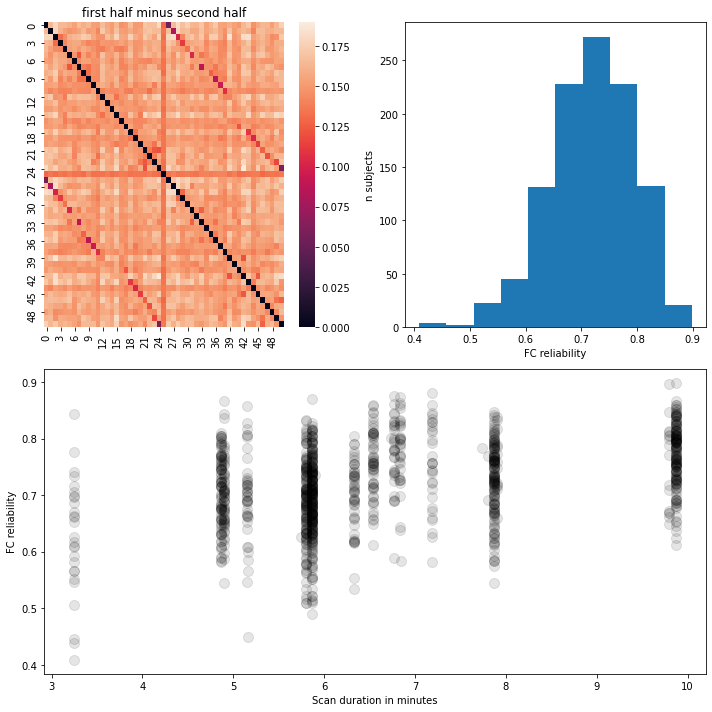

In [253]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
sns.heatmap(diff.mean(axis=0))
plt.title('first half minus second half')


plt.subplot(2,2,2)
plt.hist(halves_corr)
plt.xlabel('FC reliability')
plt.ylabel('n subjects')


plt.subplot(2,1,2)
plt.plot(scan_lenghts,halves_corr,'k.',markersize=20,alpha=.1)
#plt.plot(halves_corr,scan_lenghts,'k.',markersize=20,alpha=.1)
plt.xlabel('Scan duration in minutes')
plt.ylabel('FC reliability')

plt.tight_layout()

In [95]:
(halves_corr<.5).sum()

5

In [382]:
ranks = []
rdelta = []
within_corrs = []
for s in tqdm(range(n)):
    vec = get_triu(cmats[s,:,:,0])
    within = corr(get_triu(cmats[s,:,:,1]),get_triu(cmats[s,:,:,0]))[0,1]

    other_subs = [i for i in np.arange(n) if i!=s]
    across = [corr(get_triu(cmats[s,:,:,1]),get_triu(cmats[ss,:,:,1]))[0,1] for ss in other_subs]

    rank = (within < across).sum()+1
    ranks.append(rank)
    rdelta.append(within-max(across))
    within_corrs.append(within)

#first_vec = get_triu(cmats[s,:,:,0])
#second_vec = get_triu(cmats[s,:,:,1])
#other_vecs = get_triu(cmats[s,:,:,1])

100%|██████████| 1086/1086 [02:55<00:00,  6.19it/s]


In [163]:
# ranks = []
# rdelta = []
# for s in tqdm(range(n)):
#     vec = get_triu(cmats[s,:,:,0])
#     within = corr(get_triu(cmats[s,:,:,1]),get_triu(cmats[s,:,:,0]))[0,1]

#     other_subs = [i for i in np.arange(n) if i!=s]
#     across = [corr(get_triu(cmats[s,:,:,1]),get_triu(cmats[ss,:,:,0]))[0,1] for ss in other_subs]

#     rank = (within < across).sum()+1
#     ranks.append(rank)
#     rdelta.append(within-max(across))

# #first_vec = get_triu(cmats[s,:,:,0])
# #second_vec = get_triu(cmats[s,:,:,1])
# #other_vecs = get_triu(cmats[s,:,:,1])

100%|██████████| 1086/1086 [02:55<00:00,  6.18it/s]


In [263]:
ranks=np.array(ranks)

In [265]:
(ranks==1).mean().round(4)

0.9171

In [269]:
(ranks!=1).sum()

90

<AxesSubplot:ylabel='Count'>

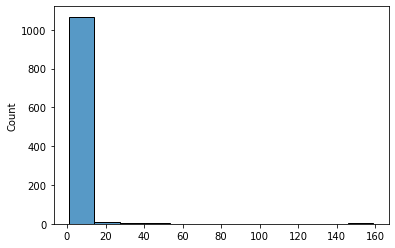

In [266]:
sns.histplot(ranks)
#sns.histplot((ranks!=1)*1)

Text(0.5, 0, 'Scan duration')

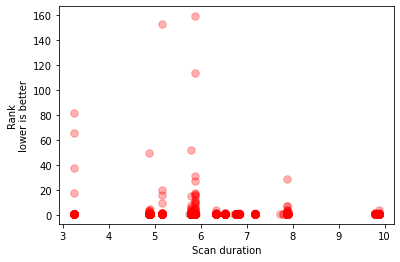

In [267]:
plt.plot(scan_lenghts,ranks,'r.',markersize=15,alpha=.3)
plt.ylabel('Rank\nlower is better')
plt.xlabel('Scan duration')

Text(0, 0.5, 'Similarity Rank')

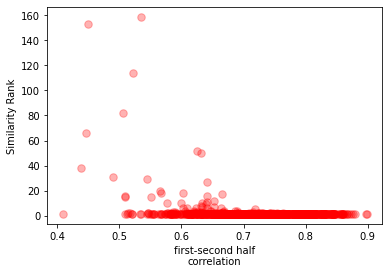

In [268]:
plt.plot(halves_corr,ranks,'r.',markersize=15,alpha=.3)
plt.xlabel('first-second half\ncorrelation')
plt.ylabel('Similarity Rank')

In [298]:
vec = np.arange(min(scan_lenghts),max(scan_lenghts),1)
vec

array([3.25, 4.25, 5.25, 6.25, 7.25, 8.25, 9.25])

In [299]:
count = []
[count.append((scan_lenghts>=val).sum()) for val in vec];

<ipython-input-314-5200f7eca5a8>:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


Text(0.5, 1.0, 'Scan length CDF')

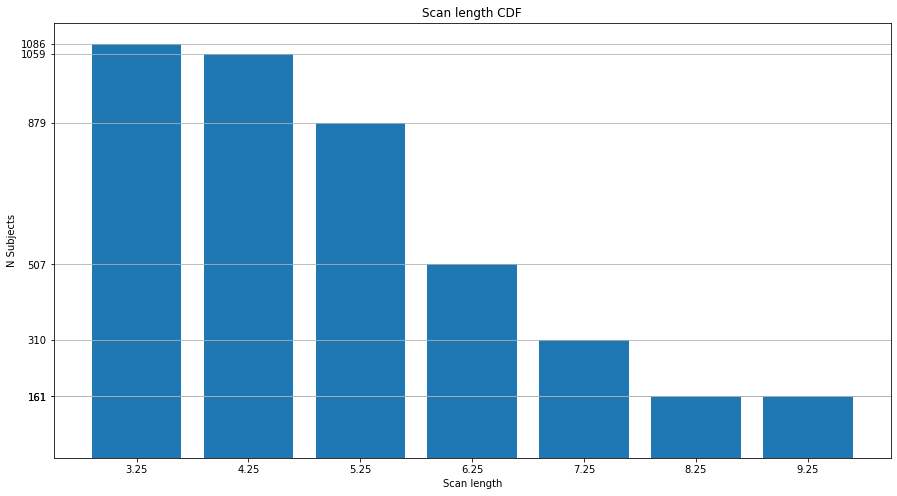

In [314]:
plt.figure(figsize=(15,8))
xs = np.arange(len(count))
plt.bar(xs,count)
plt.xticks(xs,labels=vec);
plt.yticks(count);

ax = plt.axes()        
ax.yaxis.grid() # horizontal lines
plt.ylabel('N Subjects')
plt.xlabel('Scan length')
plt.title('Scan length CDF')

In [ ]:
#### MOTION

In [318]:
df = pd.read_csv('../Data/ABIDE_df.csv')
df = df.iloc[~pd.isna(df['bids_folder'].values)]
df.head(3)

,Unnamed: 0,participant_id,DX_GROUP,DSM_IV_TR,AGE_AT_SCAN,SEX,HANDEDNESS_CATEGORY,HANDEDNESS_SCORES,FIQ,VIQ,...,WISC_IV_PIC_CON_SCALED,WISC_IV_MATRIX_SCALED,WISC_IV_DIGIT_SPAN_SCALED,WISC_IV_LET_NUM_SCALED,WISC_IV_CODING_SCALED,WISC_IV_SYM_SCALED,EYE_STATUS_AT_SCAN,AGE_AT_MPRAGE,BMI,bids_folder
0,0,50002,1,1,16.77,1,Ambi,NaN,103.0,116.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,sub-Pitt0050002
1,1,50003,1,1,24.45,1,R,NaN,124.0,128.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,sub-Pitt0050003
2,2,50004,1,1,19.09,1,R,NaN,113.0,108.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,sub-Pitt0050004


In [319]:
# COLLECT MOTION ARTEFACTS
mot_fn_temp = '../../data/ABIDE/Outputs/cpac/raw_outputs_rerun/pipeline_abide_rerun/00{subNum}_session_1/movement_parameters/_scan_rest_1_rest/fristons_twenty_four.1D'

In [320]:
subNums = df['participant_id'].values

In [321]:
mots = []
mot_subs = []
for s in tqdm(range(len(subNums))):
    subMotfn = mot_fn_temp.format(subNum=subNums[s])
    if os.path.exists(subMotfn):
        m = np.loadtxt(subMotfn).mean()
        mots.append(m)
        mot_subs.append(subNums[s])

100%|██████████| 1102/1102 [00:25<00:00, 43.64it/s]


In [327]:
mot_df = pd.DataFrame()

In [343]:
mot_df['mot'] = mots
mot_df['subNum'] = mot_subs
sub_ids = [df['bids_folder'].values[np.nonzero(df['participant_id'].values==val)[0][0]] for val in mot_df['subNum'].values]
mot_df['bids_folder'] = sub_ids

In [350]:
slice_ = np.array([val in subs for val in mot_df['bids_folder'].values])

In [351]:
this_mot_df = mot_df.iloc[slice_]

In [360]:
assert all([this_mot_df['bids_folder'].values[0]==subs[0] for s in range(len(subs))]),'out of order'

(array([1.084e+03, 1.100e+01, 2.000e+00, 3.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([-6.13441453e-05,  6.22538377e-01,  1.24513810e+00,  1.86773782e+00,
         2.49033754e+00,  3.11293726e+00,  3.73553699e+00,  4.35813671e+00,
         4.98073643e+00,  5.60333615e+00,  6.22593587e+00]),
 <BarContainer object of 10 artists>)

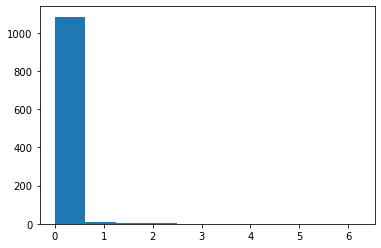

In [325]:
plt.hist(mots)

In [404]:
import scipy
pdist = scipy.spatial.distance.pdist
squareform = scipy.spatial.distance.squareform
#mot_sim = squareform(pdist(this_mot_df['mot'].values[:,np.newaxis]))

In [429]:
sub_slice = this_mot_df['mot'].values<1;print(sub_slice.sum())
rdm_mot = make_RDM(this_mot_df['mot'].values[sub_slice])
rdm_lenght = make_RDM(scan_lenghts[sub_slice],data_scale='ordinal')
rdm_rel = make_RDM(np.array(within_corrs)[sub_slice])

1074


In [479]:
within_corrs = np.array(within_corrs)
corr(this_mot_df['mot'].values[sub_slice],within_corrs[sub_slice])

KendalltauResult(correlation=-0.073359880805407, pvalue=0.0003177915141865024)

Text(0.5, 1.0, 'scanning length similarity')

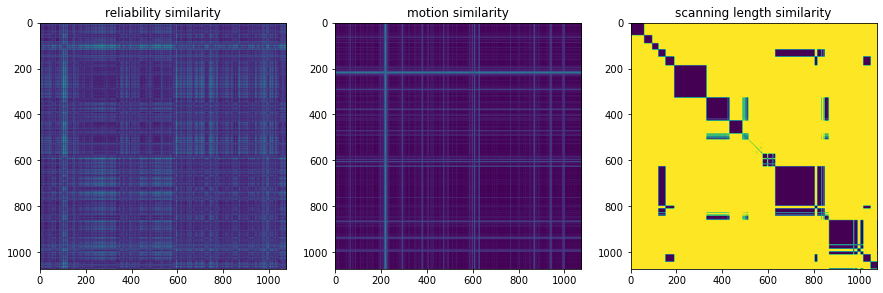

In [458]:
plt.figure(figsize=(15,5))
i=0
i+=1;plt.subplot(1,3,i);plt.imshow(rdm_rel);plt.title('reliability similarity')
i+=1;plt.subplot(1,3,i);plt.imshow(rdm_mot);plt.title('motion similarity')
i+=1;plt.subplot(1,3,i);plt.imshow(rdm_lenght);plt.title('scanning length similarity')

In [430]:
corr = scipy.stats.kendalltau

In [471]:
rsa = np.zeros((3,3))*np.nan

In [472]:
rsa[0,1] = corr(get_triu(rdm_mot),get_triu(rdm_rel))[0]
rsa[1,2] = corr(get_triu(rdm_mot),get_triu(rdm_lenght))[0]
rsa[0,2] = corr(get_triu(rdm_rel),get_triu(rdm_lenght))[0]
xticks = ['Reliability','Motion','Scan Length']

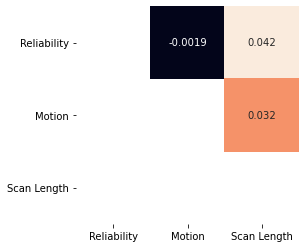

In [473]:
plt.figure(figsize=(4,4));
sns.heatmap(rsa,annot=True,cbar=False,xticklabels=xticks);
plt.yticks(np.arange(3)+.5,labels=xticks,rotation=0);

0.041809223027500016